In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .appName("MYSQL Connection Example") \
        .getOrCreate()

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.jars", "/path/to/mysql-connector-java-8.0.33.jar") \
    .getOrCreate()


In [3]:
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
jdbc_hostname = "localhost"
jdbc_port = 3306
database = "churn_prediction"
jdbc_url = f"jdbc:mysql://{jdbc_hostname}:{jdbc_port}/{database}"

In [4]:
connection_properties = {

    "user":"root",
    "password":"easwari",
    "driver":"com.mysql.cj.jdbc.Driver"
}

In [5]:
table = "customers"

In [8]:
try:
    df = spark.read.jdbc(url=jdbc_url, table=table, properties=connection_properties)
    df.show()
except Exception as e:
    print(f"error as {e}")

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+---------------+--------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|numAdminTickets|numTechTickets|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+------

In [9]:
df.createOrReplaceTempView("customers")

In [10]:
result = spark.sql('SELECT gender FROM customers WHERE gender = "Male"')
result.show()

+------+
|gender|
+------+
|  Male|
|  Male|
|  Male|
|  Male|
|  Male|
|  Male|
|  Male|
|  Male|
|  Male|
|  Male|
|  Male|
|  Male|
|  Male|
|  Male|
|  Male|
|  Male|
|  Male|
|  Male|
|  Male|
|  Male|
+------+
only showing top 20 rows



In [11]:
result2 = spark.sql( '''
                     with cte1 as
                     (select gender, count(customerid) as `Total_no_of_customers`
                     from customers
                     group by gender)
                     , cte2 as
                     (select gender, count(Churn) as `churn`
                     from customers
                     where churn = 'Yes'
                     group by gender)
                     select cte1.*, cte2.churn, (`Total_no_of_customers` - churn) as `retained`
                     from cte1 inner join cte2 
                     on cte1.gender = cte2.gender
                     '''
                     )

In [12]:
result2.show()

+------+---------------------+-----+--------+
|gender|Total_no_of_customers|churn|retained|
+------+---------------------+-----+--------+
|Female|                 3483|  939|    2544|
|  Male|                 3549|  930|    2619|
+------+---------------------+-----+--------+



In [18]:
df_pd = result2.toPandas()

In [19]:
type(result2)

pyspark.sql.dataframe.DataFrame

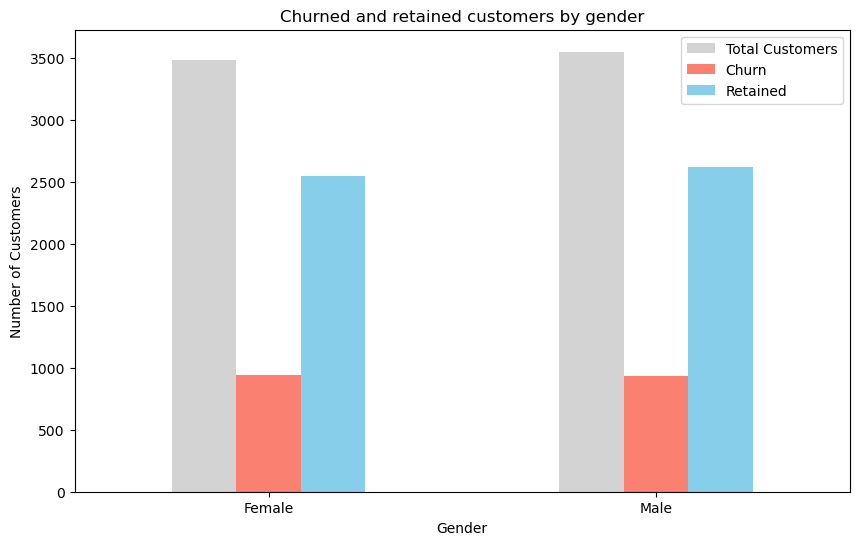

In [21]:
# Plot total customers, churn, and retained counts side-by-side for each gender
df_pd.plot(x='gender', y=['Total_no_of_customers', 'churn', 'retained'], kind='bar', color=['lightgray', 'salmon', 'skyblue'], figsize=(10, 6))

# Add labels and title
plt.xlabel('Gender')
plt.ylabel('Number of Customers')
plt.title('Churned and retained customers by gender')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.legend(['Total Customers', 'Churn', 'Retained'])

# Show plot
plt.show()


--> find the churned and retained customers for those who married and unmarried

In [25]:
spark.sql('''select partner from customers''').show()

+-------+
|partner|
+-------+
|    Yes|
|     No|
|     No|
|     No|
|     No|
|     No|
|     No|
|     No|
|    Yes|
|     No|
|    Yes|
|     No|
|    Yes|
|     No|
|     No|
|    Yes|
|     No|
|     No|
|    Yes|
|     No|
+-------+
only showing top 20 rows



In [57]:
result3 = spark.sql(
          '''
          with `total_customers` as
          (
          select partner, count(customerid) as `Total customers`
          from customers
          group by partner
          )
          ,`customer_retention` as
          (
          select partner,count(customerid) as `Retained customers`
          from customers
          where churn = "No"
          group by partner
          )
          select tc.partner, tc.`Total customers`, cr.`Retained customers`,
          (tc.`Total customers` - cr.`Retained customers`) as `Churned customers`
          from (total_customers as  tc) inner join (customer_retention as cr)
          on tc.partner = cr.partner
          order by partner desc
          ''')
result3.show()

+-------+---------------+------------------+-----------------+
|partner|Total customers|Retained customers|Churned customers|
+-------+---------------+------------------+-----------------+
|    Yes|           3393|              2724|              669|
|     No|           3639|              2439|             1200|
+-------+---------------+------------------+-----------------+



In [58]:
df_pd2 = result3.toPandas() 

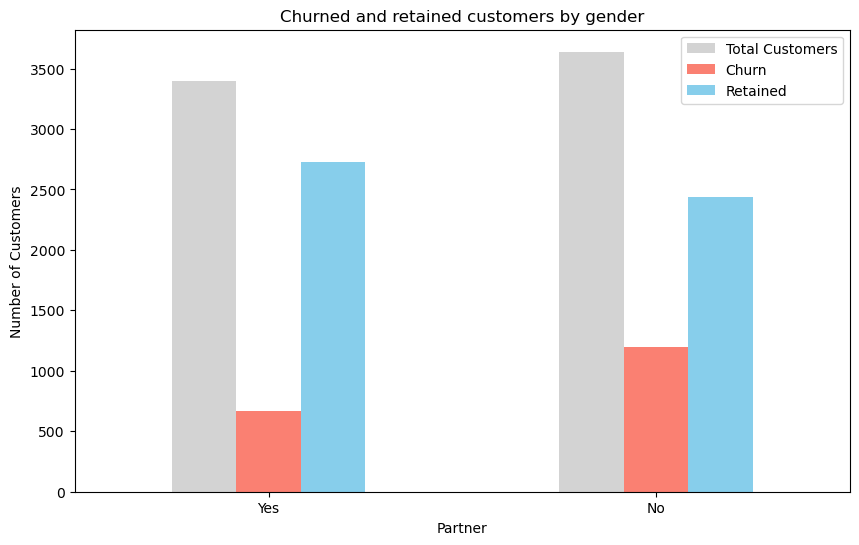

In [60]:
# Plot total customers, churn, and retained counts side-by-side for each gender
df_pd2.plot(x='partner', y=['Total customers', 'Churned customers', 'Retained customers'], 
                        kind='bar', color=['lightgray', 'salmon', 'skyblue'], figsize=(10, 6))

# Add labels and title
plt.xlabel('Partner')
plt.ylabel('Number of Customers')
plt.title('Churned and retained customers by gender')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.legend(['Total Customers', 'Churn', 'Retained'])

# Show plot
plt.show()